In this notebook, I'm going to first download the CIFAR-10 dataset (or read it from cached data) and then train a CNN on it. <br>
Here we imported pytorch libraries which we'll going to use in next cells

In [14]:
import numpy as np 
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import datasets, transforms
from torchvision.ops import MLP
from torch import nn, optim
import cv2
from tqdm import tqdm

Here we set the code runtime env, First we look for CUDA and if it's available we select it as our device, else we choose CPU env.

In [15]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('OK CUDA was avaialbe.')
else:
    device = torch.device('cpu')
print(device)

OK CUDA was avaialbe.
cuda


In this cell, we'ere going to define a list of transforms that we want to apply on our data before training.<br>
Downloaded dataset samples are in form of PIL images, but in order to create torch model over them, we need them in shape of tensors, so the first four transforms are augmentations, First augmentation used to change the color brightness and satur of images, the next one randomly flip the image with probability of 0.5 (expecting to have 50% of images flipped) and the next of randomly flip the image but this time vertically. The last augmentation randomly rotate each image from -10 to +10 degrees. After that we used ToTensor() to convert PIL objects to tensors.<br>
The next transform is going to normalize input images. We define normalization parameters for each channel seperately.<br>
Normalization and Augmentation params are the same as the params used by this repo:<br>
https://github.com/priyavrat-misra/cifar10

In [16]:
transform_train = transforms.Compose([
    # Augmentations
    transforms.ColorJitter(brightness=0.25, saturation=0.1),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(10), # -10 to +10 degrees
    
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

Now we're going to download the data (CIFAR10) and sperate it into two parts, train and test.<br>
If a previously downloaded data is avaialable we're gonna use it.<br>
We also run previously defined transforms on our dataset. (ToTensor, Normalize)

In [17]:
train_path = 'ds/train/'
test_path = 'ds/test/'
print(f'- Downlaoding training set')
dstrain = datasets.CIFAR10(train_path, train=True, download=True, transform=transform_train)
print(f'- Downloading testing set')
dstest = datasets.CIFAR10(test_path, train=False, download=True, transform=transform_test)

- Downlaoding training set
Files already downloaded and verified
- Downloading testing set
Files already downloaded and verified


Here in this cell, we're gonna see some basic information about our dataset. It has 50000 training images and 10000 test ones. <br>
Total 60000 samples divided into 10 classes:<br>
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']<br>
Images are 32*32 RGB and for each class we have 6000 samples.<br>
Dataset is sperated in 5 trainig batch and 1 test batch, each containing 10000 images.<br>
Images are not divided between training batches uniformly (which means, one batch may contains more images for one class than the others), But there are exactly 5000 trainig image and 1000 test image for each class.<br>
More information about this dataset here: https://www.cs.toronto.edu/~kriz/cifar.html

In [18]:
print(dstrain)
print(dstest)
print(len(dstrain.classes))
print(dstrain.classes)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ds/train/
    Split: Train
    StandardTransform
Transform: Compose(
               ColorJitter(brightness=[0.75, 1.25], contrast=None, saturation=[0.9, 1.1], hue=None)
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ds/test/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )
10
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Here we defined a loader which is a wrapper around data that can help us divide data into batches and only load those batches that we need instead of loading the whole dataset into memory. It's saving lots of memory.<br>
Batch Size = 16 (means training would use 16 images loss at each iteration)

In [19]:
batch = 16
ldtrain = torch.utils.data.DataLoader(dstrain, batch_size=batch, shuffle=True)
ldval = torch.utils.data.DataLoader(dstest, batch_size=batch, shuffle=True)

Now let's show a subset of images, to do so, first we converted train set loaded to a python iterator and get the first iteration value out of it. 

In [20]:
dataiter = iter(ldtrain)
images ,labels = next(dataiter)

print(images.shape)
print(labels.shape)

torch.Size([16, 3, 32, 32])
torch.Size([16])


Now in this cell, we just printed a batch of the images,<br>
Notice that to do so, we need to move RGB channel to the last axis of tensor<br>
Images may does not look like the original ones, because we normalized then and now we are reversing the normalization. So it may look a bit odd

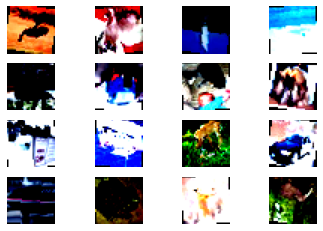

In [21]:
noi = 4
num_of_images = noi * noi
for index in range(1, num_of_images+1):
    img = images[index-1]
    
    _ = plt.subplot(noi,noi, index)
    _ = plt.axis('off')
    _ = plt.imshow(img.moveaxis(0, -1))

In this cell, we're defining the architecture of CNN model which we are going to use to model our CIFAR10 dataset.

In [22]:
model = nn.Sequential(
    nn.Conv2d(3, 32, (3,3), (1,1), 'same'),
    nn.ReLU(),
    nn.Conv2d(32, 64, (3,3), (1,1), 'valid'),
    nn.ReLU(),
    nn.MaxPool2d((2,2)),

    nn.Conv2d(64, 128, (3,3), (1,1), 'same'),
    nn.ReLU(),
    nn.Conv2d(128, 256, (3,3), (1,1), 'valid'),
    nn.ReLU(),
    nn.MaxPool2d((2,2)),

    nn.Conv2d(256, 512, (3,3), (1,1), 'same'),
    nn.ReLU(),
    nn.Conv2d(512, 1024, (3,3), (1,1), 'valid'),
    nn.ReLU(),
    nn.MaxPool2d((2,2)),

    nn.Flatten(),
    nn.Linear(4096, 1024),
    nn.ReLU(),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),

    nn.Linear(256, 10)
)

print(model)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (1): ReLU()
  (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (3): ReLU()
  (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (6): ReLU()
  (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (8): ReLU()
  (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (11): ReLU()
  (12): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (13): ReLU()
  (14): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (15): Flatten(start_dim=1, end_dim=-1)
  (16): Linear(in_features=4096, out_features=1024, bias=True)
  (17): ReLU()
  (18): Linear(in_features=1024, out_features=512, bias=True)
  (19)

binding model object to specified training hardware

In [23]:
_ = model.to(device)

defining learning rate, number of epochs, validation frequency, optimizer and loss function

In [24]:
n_epochs = 120
val_freq = 5

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [25]:
def accuracy(y_pred, y):
    """
    Calculating the accuracy of given batch.
    input(s):
    y_pred (ndarray): predicted logits or the output of the model.
    y (ndarray): labels
    """
    pred_idx = y_pred.max(1, keepdim=True)[1]
    correct = pred_idx.eq(y.view_as(pred_idx)).sum().item()
    return correct / len(y)

In [26]:
history = dict()
history['train_loss']= list()
history['train_acc']= list()
history['val_loss']= list()
history['val_acc']= list()
for epoch in range(n_epochs):
    running_loss = 0
    running_acc = 0

    model.train()
    for idx, (X, y) in enumerate(tqdm(ldtrain)):
        optimizer.zero_grad()
        X, y = X.to(device), y.to(device)
        y_hat = model(X)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_acc += accuracy(y_hat, y)
    else:
        running_loss = running_loss/ len(ldtrain)
        running_acc = running_acc / len(ldtrain)
        history['train_loss'].append(running_loss)
        history['train_acc'].append(running_acc)
        print(f'Epoch {epoch+1}/{n_epochs} : training loss: {running_loss}, training acc: {running_acc}')




    if epoch% val_freq == val_freq-1:
        running_loss = 0
        running_acc = 0
        model.eval()
        with torch.no_grad():
            for idx, (X, y) in enumerate(tqdm(ldval)):
                X, y = X.to(device), y.to(device) 
                y_hat = model(X)
                loss = criterion(y_hat, y)

                running_loss += loss.item()
                running_acc += accuracy(y_hat, y)
            else:
                running_loss = running_loss/ len(ldval)
                running_acc = running_acc / len(ldval)
                history['val_loss'].append(running_loss)
                history['val_acc'].append(running_acc)
                print(f'Epoch {epoch+1}/{n_epochs} : validation loss: {running_loss}, validation acc: {running_acc}')

100%|██████████| 3125/3125 [01:01<00:00, 51.15it/s]


Epoch 1/120 : training loss: 2.3026918339538573, training acc: 0.10192


100%|██████████| 3125/3125 [01:02<00:00, 49.85it/s]


Epoch 2/120 : training loss: 2.3021504058074953, training acc: 0.10568


100%|██████████| 3125/3125 [01:00<00:00, 51.65it/s]


Epoch 3/120 : training loss: 2.2594172634887695, training acc: 0.14502


100%|██████████| 3125/3125 [01:00<00:00, 51.75it/s]


Epoch 4/120 : training loss: 1.8981099732589721, training acc: 0.27816


100%|██████████| 3125/3125 [00:59<00:00, 52.11it/s]


Epoch 5/120 : training loss: 1.707440525932312, training acc: 0.34632


100%|██████████| 625/625 [00:04<00:00, 154.55it/s]


Epoch 5/120 : validation loss: 1.6340442470550538, validation acc: 0.374


100%|██████████| 3125/3125 [01:00<00:00, 51.81it/s]


Epoch 6/120 : training loss: 1.5926426438713073, training acc: 0.39732


100%|██████████| 3125/3125 [01:01<00:00, 51.01it/s]


Epoch 7/120 : training loss: 1.454494803981781, training acc: 0.45816


100%|██████████| 3125/3125 [01:00<00:00, 51.86it/s]


Epoch 8/120 : training loss: 1.3171366520500183, training acc: 0.51736


100%|██████████| 3125/3125 [00:59<00:00, 52.20it/s]


Epoch 9/120 : training loss: 1.2184747601509094, training acc: 0.55846


100%|██████████| 3125/3125 [01:00<00:00, 51.99it/s]


Epoch 10/120 : training loss: 1.130611220331192, training acc: 0.5907


100%|██████████| 625/625 [00:04<00:00, 154.87it/s]


Epoch 10/120 : validation loss: 1.0912291279315949, validation acc: 0.6006


100%|██████████| 3125/3125 [01:01<00:00, 50.50it/s]


Epoch 11/120 : training loss: 1.053636264781952, training acc: 0.61828


100%|██████████| 3125/3125 [01:00<00:00, 51.62it/s]


Epoch 12/120 : training loss: 0.9817185905694962, training acc: 0.64652


100%|██████████| 3125/3125 [01:00<00:00, 51.87it/s]


Epoch 13/120 : training loss: 0.9101145694017411, training acc: 0.67338


100%|██████████| 3125/3125 [00:59<00:00, 52.20it/s]


Epoch 14/120 : training loss: 0.8490248207616806, training acc: 0.69604


100%|██████████| 3125/3125 [01:01<00:00, 50.99it/s]


Epoch 15/120 : training loss: 0.7918794337797165, training acc: 0.71852


100%|██████████| 625/625 [00:04<00:00, 155.13it/s]


Epoch 15/120 : validation loss: 0.7592653054714202, validation acc: 0.73


100%|██████████| 3125/3125 [01:00<00:00, 51.91it/s]


Epoch 16/120 : training loss: 0.736383831243515, training acc: 0.73904


100%|██████████| 3125/3125 [00:59<00:00, 52.25it/s]


Epoch 17/120 : training loss: 0.6877170194661617, training acc: 0.7572


100%|██████████| 3125/3125 [01:00<00:00, 52.05it/s]


Epoch 18/120 : training loss: 0.6524971602082252, training acc: 0.77034


100%|██████████| 3125/3125 [01:00<00:00, 51.28it/s]


Epoch 19/120 : training loss: 0.6139921542704105, training acc: 0.78338


100%|██████████| 3125/3125 [00:59<00:00, 52.10it/s]


Epoch 20/120 : training loss: 0.5796708373439312, training acc: 0.79486


100%|██████████| 625/625 [00:03<00:00, 158.36it/s]


Epoch 20/120 : validation loss: 0.6769501705884934, validation acc: 0.7655


100%|██████████| 3125/3125 [00:59<00:00, 52.82it/s]


Epoch 21/120 : training loss: 0.5462573404657841, training acc: 0.81052


100%|██████████| 3125/3125 [00:59<00:00, 52.92it/s]


Epoch 22/120 : training loss: 0.5196906531709432, training acc: 0.81792


100%|██████████| 3125/3125 [00:59<00:00, 52.12it/s]


Epoch 23/120 : training loss: 0.4919005271345377, training acc: 0.8275


100%|██████████| 3125/3125 [01:00<00:00, 52.01it/s]


Epoch 24/120 : training loss: 0.47208967879652974, training acc: 0.83568


100%|██████████| 3125/3125 [00:59<00:00, 52.55it/s]


Epoch 25/120 : training loss: 0.44644139768868685, training acc: 0.84458


100%|██████████| 625/625 [00:04<00:00, 156.07it/s]


Epoch 25/120 : validation loss: 0.5688551875472069, validation acc: 0.8076


100%|██████████| 3125/3125 [00:59<00:00, 52.28it/s]


Epoch 26/120 : training loss: 0.4160220176047087, training acc: 0.85556


100%|██████████| 3125/3125 [00:59<00:00, 52.39it/s]


Epoch 27/120 : training loss: 0.40058028607308865, training acc: 0.86008


100%|██████████| 3125/3125 [00:59<00:00, 52.68it/s]


Epoch 28/120 : training loss: 0.3764443229687214, training acc: 0.8699


100%|██████████| 3125/3125 [00:59<00:00, 52.52it/s]


Epoch 29/120 : training loss: 0.3602796114958823, training acc: 0.87412


100%|██████████| 3125/3125 [00:59<00:00, 52.24it/s]


Epoch 30/120 : training loss: 0.34668787597477435, training acc: 0.87952


100%|██████████| 625/625 [00:03<00:00, 159.21it/s]


Epoch 30/120 : validation loss: 0.5622335493534804, validation acc: 0.8185


100%|██████████| 3125/3125 [00:59<00:00, 52.85it/s]


Epoch 31/120 : training loss: 0.3224760787278414, training acc: 0.88804


100%|██████████| 3125/3125 [00:59<00:00, 52.54it/s]


Epoch 32/120 : training loss: 0.30969325340121984, training acc: 0.89292


100%|██████████| 3125/3125 [00:59<00:00, 52.50it/s]


Epoch 33/120 : training loss: 0.2927482983329892, training acc: 0.89774


100%|██████████| 3125/3125 [00:58<00:00, 53.09it/s]


Epoch 34/120 : training loss: 0.2772919709903002, training acc: 0.9039


100%|██████████| 3125/3125 [00:59<00:00, 52.45it/s]


Epoch 35/120 : training loss: 0.2617974495448172, training acc: 0.9093


100%|██████████| 625/625 [00:03<00:00, 158.47it/s]


Epoch 35/120 : validation loss: 0.5982934343189001, validation acc: 0.8211


100%|██████████| 3125/3125 [00:59<00:00, 52.47it/s]


Epoch 36/120 : training loss: 0.25038819939367474, training acc: 0.91264


100%|██████████| 3125/3125 [00:58<00:00, 53.02it/s]


Epoch 37/120 : training loss: 0.23893617751300336, training acc: 0.9167


100%|██████████| 3125/3125 [00:59<00:00, 52.66it/s]


Epoch 38/120 : training loss: 0.23170476927615702, training acc: 0.91808


100%|██████████| 3125/3125 [00:59<00:00, 52.59it/s]


Epoch 39/120 : training loss: 0.21648825893864035, training acc: 0.92524


100%|██████████| 3125/3125 [00:59<00:00, 52.71it/s]


Epoch 40/120 : training loss: 0.20748026173092424, training acc: 0.92908


100%|██████████| 625/625 [00:03<00:00, 158.67it/s]


Epoch 40/120 : validation loss: 0.6390933432109654, validation acc: 0.8164


100%|██████████| 3125/3125 [00:59<00:00, 52.29it/s]


Epoch 41/120 : training loss: 0.19738844182977452, training acc: 0.9312


100%|██████████| 3125/3125 [00:59<00:00, 52.89it/s]


Epoch 42/120 : training loss: 0.19088803698785603, training acc: 0.9328


100%|██████████| 3125/3125 [00:59<00:00, 52.83it/s]


Epoch 43/120 : training loss: 0.1833156101679802, training acc: 0.93708


100%|██████████| 3125/3125 [01:00<00:00, 52.07it/s]


Epoch 44/120 : training loss: 0.1737579075511545, training acc: 0.9394


100%|██████████| 3125/3125 [00:59<00:00, 52.81it/s]


Epoch 45/120 : training loss: 0.16798580266093835, training acc: 0.94122


100%|██████████| 625/625 [00:03<00:00, 158.02it/s]


Epoch 45/120 : validation loss: 0.6451240878872574, validation acc: 0.8266


100%|██████████| 3125/3125 [00:59<00:00, 52.69it/s]


Epoch 46/120 : training loss: 0.15830417388133705, training acc: 0.9458


100%|██████████| 3125/3125 [00:59<00:00, 52.24it/s]


Epoch 47/120 : training loss: 0.1533917440897878, training acc: 0.94722


100%|██████████| 3125/3125 [00:59<00:00, 52.62it/s]


Epoch 48/120 : training loss: 0.15165504095431417, training acc: 0.94758


100%|██████████| 3125/3125 [00:59<00:00, 52.92it/s]


Epoch 49/120 : training loss: 0.1441377609519474, training acc: 0.95036


100%|██████████| 3125/3125 [00:59<00:00, 52.29it/s]


Epoch 50/120 : training loss: 0.13538282699073664, training acc: 0.9525


100%|██████████| 625/625 [00:03<00:00, 158.62it/s]


Epoch 50/120 : validation loss: 0.6863374461721629, validation acc: 0.8245


100%|██████████| 3125/3125 [00:59<00:00, 52.83it/s]


Epoch 51/120 : training loss: 0.13190346802073996, training acc: 0.95448


100%|██████████| 3125/3125 [00:59<00:00, 52.66it/s]


Epoch 52/120 : training loss: 0.12589865167440847, training acc: 0.95656


100%|██████████| 3125/3125 [01:04<00:00, 48.17it/s]


Epoch 53/120 : training loss: 0.12550537273613735, training acc: 0.95626


100%|██████████| 3125/3125 [01:00<00:00, 51.95it/s]


Epoch 54/120 : training loss: 0.11564258400317282, training acc: 0.96116


100%|██████████| 3125/3125 [00:58<00:00, 53.00it/s]


Epoch 55/120 : training loss: 0.11350254388591274, training acc: 0.96082


100%|██████████| 625/625 [00:03<00:00, 160.48it/s]


Epoch 55/120 : validation loss: 0.6878203289064578, validation acc: 0.8292


100%|██████████| 3125/3125 [00:59<00:00, 52.30it/s]


Epoch 56/120 : training loss: 0.10762588976236526, training acc: 0.96304


100%|██████████| 3125/3125 [00:58<00:00, 53.11it/s]


Epoch 57/120 : training loss: 0.10625304364976473, training acc: 0.96502


100%|██████████| 3125/3125 [00:59<00:00, 52.61it/s]


Epoch 58/120 : training loss: 0.10214199337281753, training acc: 0.96464


100%|██████████| 3125/3125 [00:59<00:00, 52.49it/s]


Epoch 59/120 : training loss: 0.10011466811075806, training acc: 0.96574


100%|██████████| 3125/3125 [00:58<00:00, 53.08it/s]


Epoch 60/120 : training loss: 0.09370299328506458, training acc: 0.968


100%|██████████| 625/625 [00:03<00:00, 159.78it/s]


Epoch 60/120 : validation loss: 0.7104551580974832, validation acc: 0.8351


100%|██████████| 3125/3125 [00:58<00:00, 53.38it/s]


Epoch 61/120 : training loss: 0.08993606829716824, training acc: 0.969


100%|██████████| 3125/3125 [00:59<00:00, 52.60it/s]


Epoch 62/120 : training loss: 0.09139089035891229, training acc: 0.96922


100%|██████████| 3125/3125 [00:58<00:00, 53.21it/s]


Epoch 63/120 : training loss: 0.08766750880550593, training acc: 0.9704


100%|██████████| 3125/3125 [00:58<00:00, 53.25it/s]


Epoch 64/120 : training loss: 0.08350808358917479, training acc: 0.97194


100%|██████████| 3125/3125 [00:58<00:00, 53.26it/s]


Epoch 65/120 : training loss: 0.08514845952904318, training acc: 0.97054


100%|██████████| 625/625 [00:03<00:00, 159.69it/s]


Epoch 65/120 : validation loss: 0.6659757353086024, validation acc: 0.8411


100%|██████████| 3125/3125 [00:59<00:00, 52.87it/s]


Epoch 66/120 : training loss: 0.07920545153653016, training acc: 0.9729


100%|██████████| 3125/3125 [00:59<00:00, 52.94it/s]


Epoch 67/120 : training loss: 0.07896896087941131, training acc: 0.97304


100%|██████████| 3125/3125 [00:58<00:00, 53.37it/s]


Epoch 68/120 : training loss: 0.07480865615053335, training acc: 0.97446


100%|██████████| 3125/3125 [00:59<00:00, 52.68it/s]


Epoch 69/120 : training loss: 0.07303183783128159, training acc: 0.9749


100%|██████████| 3125/3125 [00:59<00:00, 52.88it/s]


Epoch 70/120 : training loss: 0.07530097576603177, training acc: 0.97472


100%|██████████| 625/625 [00:03<00:00, 161.87it/s]


Epoch 70/120 : validation loss: 0.6940115207366645, validation acc: 0.8394


100%|██████████| 3125/3125 [00:58<00:00, 53.22it/s]


Epoch 71/120 : training loss: 0.07111541889812041, training acc: 0.97562


100%|██████████| 3125/3125 [00:59<00:00, 52.54it/s]


Epoch 72/120 : training loss: 0.06751005054036738, training acc: 0.97678


100%|██████████| 3125/3125 [00:58<00:00, 53.56it/s]


Epoch 73/120 : training loss: 0.0682719850108854, training acc: 0.97612


100%|██████████| 3125/3125 [00:58<00:00, 53.34it/s]


Epoch 74/120 : training loss: 0.06306328955870937, training acc: 0.9788


100%|██████████| 3125/3125 [00:59<00:00, 52.33it/s]


Epoch 75/120 : training loss: 0.06449473040696001, training acc: 0.97746


100%|██████████| 625/625 [00:04<00:00, 156.02it/s]


Epoch 75/120 : validation loss: 0.7405733968280256, validation acc: 0.8349


100%|██████████| 3125/3125 [00:59<00:00, 52.90it/s]


Epoch 76/120 : training loss: 0.06131883412684198, training acc: 0.97912


100%|██████████| 3125/3125 [00:59<00:00, 52.76it/s]


Epoch 77/120 : training loss: 0.06036765329900256, training acc: 0.97984


100%|██████████| 3125/3125 [01:00<00:00, 51.89it/s]


Epoch 78/120 : training loss: 0.0604810033608001, training acc: 0.97984


100%|██████████| 3125/3125 [00:59<00:00, 52.94it/s]


Epoch 79/120 : training loss: 0.05543168976982473, training acc: 0.98152


100%|██████████| 3125/3125 [00:59<00:00, 52.48it/s]


Epoch 80/120 : training loss: 0.05783023151219008, training acc: 0.97962


100%|██████████| 625/625 [00:03<00:00, 159.28it/s]


Epoch 80/120 : validation loss: 0.7666653426920995, validation acc: 0.8369


100%|██████████| 3125/3125 [00:59<00:00, 52.81it/s]


Epoch 81/120 : training loss: 0.05575804976515181, training acc: 0.98096


100%|██████████| 3125/3125 [00:59<00:00, 52.87it/s]


Epoch 82/120 : training loss: 0.05372881960402359, training acc: 0.98212


100%|██████████| 3125/3125 [00:59<00:00, 52.39it/s]


Epoch 83/120 : training loss: 0.05109161150770226, training acc: 0.9827


100%|██████████| 3125/3125 [00:58<00:00, 53.24it/s]


Epoch 84/120 : training loss: 0.05794423748777554, training acc: 0.97992


100%|██████████| 3125/3125 [00:58<00:00, 53.12it/s]


Epoch 85/120 : training loss: 0.04839253525318927, training acc: 0.98388


100%|██████████| 625/625 [00:03<00:00, 160.70it/s]


Epoch 85/120 : validation loss: 0.8186256825731136, validation acc: 0.8411


100%|██████████| 3125/3125 [00:59<00:00, 52.34it/s]


Epoch 86/120 : training loss: 0.04660657940931574, training acc: 0.9843


100%|██████████| 3125/3125 [00:59<00:00, 52.78it/s]


Epoch 87/120 : training loss: 0.046648573412135595, training acc: 0.98448


100%|██████████| 3125/3125 [00:59<00:00, 52.89it/s]


Epoch 88/120 : training loss: 0.050776867324532356, training acc: 0.98292


100%|██████████| 3125/3125 [01:00<00:00, 52.01it/s]


Epoch 89/120 : training loss: 0.0503829370793447, training acc: 0.98348


100%|██████████| 3125/3125 [01:00<00:00, 51.55it/s]


Epoch 90/120 : training loss: 0.04834716207955353, training acc: 0.98372


100%|██████████| 625/625 [00:03<00:00, 157.55it/s]


Epoch 90/120 : validation loss: 0.7559974376047961, validation acc: 0.843


100%|██████████| 3125/3125 [00:59<00:00, 52.75it/s]


Epoch 91/120 : training loss: 0.04608038655929399, training acc: 0.98434


100%|██████████| 3125/3125 [00:59<00:00, 52.66it/s]


Epoch 92/120 : training loss: 0.04432818285104935, training acc: 0.9847


100%|██████████| 3125/3125 [00:59<00:00, 52.96it/s]


Epoch 93/120 : training loss: 0.043132500313236906, training acc: 0.9852


100%|██████████| 3125/3125 [01:00<00:00, 51.61it/s]


Epoch 94/120 : training loss: 0.04374429208063477, training acc: 0.98528


100%|██████████| 3125/3125 [00:59<00:00, 52.53it/s]


Epoch 95/120 : training loss: 0.04009374050226099, training acc: 0.98638


100%|██████████| 625/625 [00:03<00:00, 158.22it/s]


Epoch 95/120 : validation loss: 0.8403053766484605, validation acc: 0.841


100%|██████████| 3125/3125 [00:59<00:00, 52.27it/s]


Epoch 96/120 : training loss: 0.03750724367946008, training acc: 0.9875


100%|██████████| 3125/3125 [01:00<00:00, 51.95it/s]


Epoch 97/120 : training loss: 0.041818729301824786, training acc: 0.98602


100%|██████████| 3125/3125 [01:00<00:00, 51.78it/s]


Epoch 98/120 : training loss: 0.03932755926789614, training acc: 0.98682


100%|██████████| 3125/3125 [00:59<00:00, 52.31it/s]


Epoch 99/120 : training loss: 0.04064889390311102, training acc: 0.98722


100%|██████████| 3125/3125 [00:59<00:00, 52.22it/s]


Epoch 100/120 : training loss: 0.03468539088428224, training acc: 0.988


100%|██████████| 625/625 [00:03<00:00, 157.83it/s]


Epoch 100/120 : validation loss: 0.8592299303278443, validation acc: 0.844


100%|██████████| 3125/3125 [01:00<00:00, 51.24it/s]


Epoch 101/120 : training loss: 0.039610631174585, training acc: 0.98618


100%|██████████| 3125/3125 [00:59<00:00, 52.22it/s]


Epoch 102/120 : training loss: 0.03798982712931785, training acc: 0.98732


100%|██████████| 3125/3125 [00:59<00:00, 52.22it/s]


Epoch 103/120 : training loss: 0.03637795280410406, training acc: 0.98772


100%|██████████| 3125/3125 [00:59<00:00, 52.61it/s]


Epoch 104/120 : training loss: 0.03409710300939652, training acc: 0.9887


100%|██████████| 3125/3125 [01:00<00:00, 52.02it/s]


Epoch 105/120 : training loss: 0.031718457097036155, training acc: 0.98988


100%|██████████| 625/625 [00:03<00:00, 161.98it/s]


Epoch 105/120 : validation loss: 0.8672242729954421, validation acc: 0.841


100%|██████████| 3125/3125 [00:59<00:00, 52.81it/s]


Epoch 106/120 : training loss: 0.036107226331615165, training acc: 0.98784


100%|██████████| 3125/3125 [00:59<00:00, 52.92it/s]


Epoch 107/120 : training loss: 0.038057559581850295, training acc: 0.9874


100%|██████████| 3125/3125 [00:59<00:00, 52.73it/s]


Epoch 108/120 : training loss: 0.03417147046239741, training acc: 0.98872


100%|██████████| 3125/3125 [01:01<00:00, 51.18it/s]


Epoch 109/120 : training loss: 0.03281059895637365, training acc: 0.9889


100%|██████████| 3125/3125 [01:00<00:00, 51.98it/s]


Epoch 110/120 : training loss: 0.034037151747791324, training acc: 0.9884


100%|██████████| 625/625 [00:03<00:00, 157.74it/s]


Epoch 110/120 : validation loss: 0.8319344217623584, validation acc: 0.8445


100%|██████████| 3125/3125 [01:00<00:00, 51.52it/s]


Epoch 111/120 : training loss: 0.030824368297690963, training acc: 0.98972


100%|██████████| 3125/3125 [01:01<00:00, 50.88it/s]


Epoch 112/120 : training loss: 0.0314977943937933, training acc: 0.98984


100%|██████████| 3125/3125 [00:59<00:00, 52.16it/s]


Epoch 113/120 : training loss: 0.031863398839222665, training acc: 0.98946


100%|██████████| 3125/3125 [00:59<00:00, 52.25it/s]


Epoch 114/120 : training loss: 0.029109061177089824, training acc: 0.99028


100%|██████████| 3125/3125 [00:59<00:00, 52.67it/s]


Epoch 115/120 : training loss: 0.029811898107246444, training acc: 0.99054


100%|██████████| 625/625 [00:03<00:00, 157.48it/s]


Epoch 115/120 : validation loss: 0.8780490793423844, validation acc: 0.8465


100%|██████████| 3125/3125 [01:00<00:00, 51.65it/s]


Epoch 116/120 : training loss: 0.032250104289363916, training acc: 0.9894


100%|██████████| 3125/3125 [00:59<00:00, 52.67it/s]


Epoch 117/120 : training loss: 0.029826566320629064, training acc: 0.99016


100%|██████████| 3125/3125 [00:59<00:00, 52.80it/s]


Epoch 118/120 : training loss: 0.029055348076258262, training acc: 0.98996


100%|██████████| 3125/3125 [00:59<00:00, 52.68it/s]


Epoch 119/120 : training loss: 0.03015552154287936, training acc: 0.99008


100%|██████████| 3125/3125 [01:00<00:00, 51.90it/s]


Epoch 120/120 : training loss: 0.029012093077853806, training acc: 0.99012


100%|██████████| 625/625 [00:03<00:00, 159.30it/s]

Epoch 120/120 : validation loss: 0.8633706644905266, validation acc: 0.8479


Text(0, 0.5, 'acc')

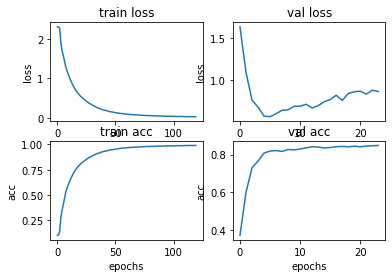

In [27]:
plt.subplot(2,2,1)
plt.title('train loss')
plt.plot(history['train_loss'])
plt.xlabel("epochs")
plt.ylabel("loss")
#plt.show()

plt.subplot(2,2,2)
plt.title('val loss')
plt.plot(history['val_loss'])
plt.xlabel("epochs")
plt.ylabel("loss")
#plt.show()

plt.subplot(2,2,3)
plt.title('train acc')
plt.plot(history['train_acc'])
plt.xlabel("epochs")
plt.ylabel("acc")
#plt.show()

plt.subplot(2,2,4)
plt.title('val acc')
plt.plot(history['val_acc'])
plt.xlabel("epochs")
plt.ylabel("acc")
#plt.show()

In [28]:
from google.colab import files

torch.save(model.state_dict(), 'checkpoint.pth')

# download checkpoint file
files.download('checkpoint.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>